In [27]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation
import seaborn as sns; sns.set()
import numpy as np
from matplotlib import pyplot as plt
from keras_tqdm import TQDMNotebookCallback
import json
import torch
from torch.utils.data import dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader
import time
import os

In [31]:
os.chdir('../../../')

In [32]:
os.getcwd()

'/Users/danieldubovski/projects/deep_query_optimization'

In [3]:
data = pd.read_csv('./input/encoded_queries.csv', 
                   converters={
                       "input_joins": lambda x: np.array(json.loads(x)),
                       "input_predicates": lambda x: np.array(json.loads(x)),
                       "input_tables": lambda x: np.array(json.loads(x)),
                       "input_joins_mask": lambda x: np.array(json.loads(x)),
                       "input_predicates_mask": lambda x: np.array(json.loads(x)),
                       "input_tables_mask": lambda x: np.array(json.loads(x)),
                   })
                   

In [4]:
data.head()

,input,runtime,input_joins,input_joins_mask,input_predicates,input_predicates_mask,input_tables,input_tables_mask
0,NaN,7.040452,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[[0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1], [0, 1, 0, ...","[[1], [1], [1], [1], [1], [1], [1], [1], [0], ...","[[0, 0, 1, 0, 1], [0, 0, 1, 1, 0], [0, 1, 0, 0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
1,NaN,7.740461,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[[0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1], [1, 0, 1, ...","[[1], [1], [1], [1], [1], [0], [0], [0], [0], ...","[[0, 0, 0, 1, 1], [0, 0, 0, 1, 0], [0, 0, 1, 0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
2,NaN,1.240947,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1], [0, 1, 1, ...","[[1], [1], [1], [1], [1], [0], [0], [0], [0], ...","[[0, 0, 1, 1, 0], [0, 1, 0, 0, 0], [0, 1, 1, 0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0...."
3,NaN,39.013127,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1], [0, 1, 0, ...","[[1], [1], [1], [1], [1], [1], [1], [1], [0], ...","[[0, 0, 1, 1, 1], [0, 0, 1, 0, 0], [0, 0, 1, 0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
4,NaN,0.188286,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[[0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1], [0, 1, 1, ...","[[1], [1], [1], [1], [1], [1], [1], [1], [0], ...","[[0, 0, 1, 0, 1], [0, 0, 1, 0, 1], [0, 1, 0, 0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [5]:
m = np.vstack(data.input_tables.values)

In [6]:
m = np.vstack(data.input_tables.apply(lambda v: [int(''.join([str(i) for i in l]),2) for l in v.tolist()]))

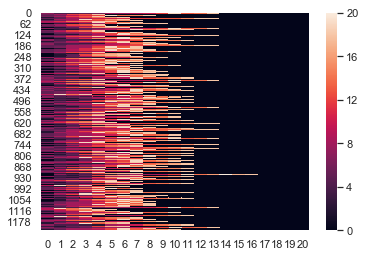

In [7]:
sns.heatmap(m)

In [8]:
data.input_tables.iloc[0].shape, data.input_joins.iloc[0].shape,data.input_predicates.iloc[0].shape

((21, 5), (210, 8), (108, 11))

In [9]:
# PREP DATA 

In [10]:
tables_tensor = torch.FloatTensor(data.input_tables)
tables_mask_tensor = torch.FloatTensor(data.input_tables_mask)

In [11]:
joins_tensor = torch.FloatTensor(data.input_joins)
joins_mask_tensor = torch.FloatTensor(data.input_joins_mask)

In [12]:
predicates_tensor = torch.FloatTensor(data.input_predicates)
predicates_mask_tensor = torch.FloatTensor(data.input_predicates_mask)

In [13]:
data.runtime.describe()

count    1225.000000
mean       11.877314
std        27.271458
min         0.009534
25%         0.336270
50%         2.549016
75%        11.899332
max       496.032421
Name: runtime, dtype: float64

In [14]:
def normalize_labels(labels, min_val=None, max_val=None):
    labels = np.array([np.log(float(l)) for l in labels])
    if min_val is None:
        min_val = labels.min()
        print("min log(label): {}".format(min_val))
    if max_val is None:
        max_val = labels.max()
        print("max log(label): {}".format(max_val))
    labels_norm = (labels - min_val) / (max_val - min_val)
    # Threshold labels
    labels_norm = np.minimum(labels_norm, 1)
    labels_norm = np.maximum(labels_norm, 0)
    return labels_norm, min_val, max_val


def unnormalize_labels(labels_norm, min_val, max_val):
    labels_norm = np.array(labels_norm, dtype=np.float32)
    labels = (labels_norm * (max_val - min_val)) + min_val
    return np.array(np.round(np.exp(labels)), dtype=np.int64)


In [15]:
normal_runtime, min_norm,max_norm = normalize_labels(data.runtime)

min log(label): -4.6529032842317255
max log(label): 6.206641289253351


In [16]:
target_tensor = torch.FloatTensor(normal_runtime)

In [17]:
split = 0.9
rows = len(data)
train_size = int(split * rows)
train_size

1102

In [18]:
labels_train = target_tensor[:train_size]
labels_test = target_tensor[train_size:]
labels_rsample = target_tensor[-8:-7]

In [19]:
f'normal: {labels_rsample}, original: {data.runtime.iloc[-8]}'

'normal: tensor([0.7311]), original: 26.73797082901001'

In [20]:
train_data = dataset.TensorDataset(
    tables_tensor[:train_size], 
    predicates_tensor[:train_size], 
    joins_tensor[:train_size], 
    target_tensor[:train_size], 
    tables_mask_tensor[:train_size],
    predicates_mask_tensor[:train_size], 
    joins_mask_tensor[:train_size]
)

In [21]:
test_data = dataset.TensorDataset(
    tables_tensor[train_size:], 
    predicates_tensor[train_size:], 
    joins_tensor[train_size:], 
    target_tensor[train_size:], 
    tables_mask_tensor[train_size:],
    predicates_mask_tensor[train_size:], 
    joins_mask_tensor[train_size:]
)

In [22]:
# RUN MODEL

In [33]:
from dqo.estimator.kipf.model import SetConv

In [34]:
tables_shape = data.input_tables.iloc[0].shape
joins_shape = data.input_joins.iloc[0].shape 
predicates_shape = data.input_predicates.iloc[0].shape

In [35]:
# 0 - size of items with padding
# 1 - bit to represent data (record size)
tables_shape, joins_shape, predicates_shape

((21, 5), (210, 8), (108, 11))

In [36]:
num_epochs = 200 # 100
batch_size = 256 #1024
out_hidden = 64 # 256
model = SetConv(tables_shape[1], predicates_shape[1], joins_shape[1], 64)

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
batch_size = 1024
train_data_loader = DataLoader(train_data, batch_size=batch_size)
test_data_loader = DataLoader(test_data, batch_size=batch_size)


In [39]:
model

SetConv(
  (sample_mlp1): Linear(in_features=5, out_features=64, bias=True)
  (sample_mlp2): Linear(in_features=64, out_features=64, bias=True)
  (predicate_mlp1): Linear(in_features=11, out_features=64, bias=True)
  (predicate_mlp2): Linear(in_features=64, out_features=64, bias=True)
  (join_mlp1): Linear(in_features=8, out_features=64, bias=True)
  (join_mlp2): Linear(in_features=64, out_features=64, bias=True)
  (out_mlp1): Linear(in_features=192, out_features=64, bias=True)
  (out_mlp2): Linear(in_features=64, out_features=1, bias=True)
)

In [436]:
model.train()

SetConv(
  (sample_mlp1): Linear(in_features=5, out_features=64, bias=True)
  (sample_mlp2): Linear(in_features=64, out_features=64, bias=True)
  (predicate_mlp1): Linear(in_features=11, out_features=64, bias=True)
  (predicate_mlp2): Linear(in_features=64, out_features=64, bias=True)
  (join_mlp1): Linear(in_features=8, out_features=64, bias=True)
  (join_mlp2): Linear(in_features=64, out_features=64, bias=True)
  (out_mlp1): Linear(in_features=192, out_features=64, bias=True)
  (out_mlp2): Linear(in_features=64, out_features=1, bias=True)
)

In [437]:
def qerror_loss(preds, targets, min_val, max_val):
    qerror = []
    preds = unnormalize_torch(preds, min_val, max_val)
    targets = unnormalize_torch(targets, min_val, max_val)
    
    for i in range(len(targets)):
        if (preds[i] > targets[i]).cpu().data.numpy()[0]:
            #loss = preds[i] / targets[i]
            loss = (preds[i] - targets[i]) ** 2
        else:
            #loss = targets[i] / preds[i]
            loss = (targets[i] - preds[i]) ** 2
        qerror.append(loss)
    return torch.mean(torch.cat(qerror))

In [438]:
def unnormalize_torch(vals, min_val, max_val):
    vals = (vals * (max_val - min_val)) + min_val
    return torch.exp(vals)

In [439]:
def print_qerror(preds_unnorm, labels_unnorm):
    qerror = []
    for i in range(len(preds_unnorm)):
        if preds_unnorm[i] > float(labels_unnorm[i]):
            qerror.append(preds_unnorm[i] / float(labels_unnorm[i]))
        else:
            qerror.append(float(labels_unnorm[i]) / float(preds_unnorm[i]))

    print("Median: {}".format(np.median(qerror)))
    print("90th percentile: {}".format(np.percentile(qerror, 90)))
    print("95th percentile: {}".format(np.percentile(qerror, 95)))
    print("99th percentile: {}".format(np.percentile(qerror, 99)))
    print("Max: {}".format(np.max(qerror)))
    print("Mean: {}".format(np.mean(qerror)))


In [443]:
min_val = min_norm
max_val = max_norm
for epoch in range(num_epochs):
    loss_total = 0.

    for batch_idx, data_batch in enumerate(train_data_loader):
        tables, predicates, joins, targets, table_masks, predicate_masks, join_masks = data_batch
        tables, predicates, joins, targets = Variable(tables), Variable(predicates), Variable(joins), Variable(targets)
        table_masks, predicate_masks, join_masks = Variable(table_masks), Variable(predicate_masks), Variable(join_masks)

        optimizer.zero_grad()
        outputs = model(tables, predicates, joins, table_masks, predicate_masks, join_masks)
        loss = qerror_loss(outputs, targets.float(), min_val, max_val)
        loss_total += loss.item()
        loss.backward()
        optimizer.step()

    print("Epoch {}, loss: {}".format(epoch, loss_total / len(train_data_loader)))



Epoch 0, loss: 186.33874130249023
Epoch 1, loss: 186.37261199951172
Epoch 2, loss: 186.34397506713867
Epoch 3, loss: 186.23007583618164
Epoch 4, loss: 186.1723976135254
Epoch 5, loss: 186.15082931518555
Epoch 6, loss: 186.1214256286621
Epoch 7, loss: 186.06994247436523
Epoch 8, loss: 185.98630905151367
Epoch 9, loss: 185.9031524658203
Epoch 10, loss: 185.98293685913086
Epoch 11, loss: 185.9712371826172
Epoch 12, loss: 185.96614837646484
Epoch 13, loss: 185.70172882080078
Epoch 14, loss: 186.1938362121582
Epoch 15, loss: 185.72624588012695
Epoch 16, loss: 185.67767333984375
Epoch 17, loss: 185.4918212890625
Epoch 18, loss: 185.46351623535156
Epoch 19, loss: 185.3696746826172
Epoch 20, loss: 185.33049774169922
Epoch 21, loss: 185.32200622558594
Epoch 22, loss: 185.2066421508789
Epoch 23, loss: 185.11282348632812
Epoch 24, loss: 185.22379302978516
Epoch 25, loss: 185.10138320922852
Epoch 26, loss: 185.0898208618164
Epoch 27, loss: 184.89475631713867
Epoch 28, loss: 185.41311264038086
Epoc

KeyboardInterrupt: 

In [444]:
def predict(model, data_loader):
    preds = []
    t_total = 0.

    model.eval()
    for batch_idx, data_batch in enumerate(data_loader):
        tables, predicates, joins, targets, tables_masks, predicate_masks, join_masks = data_batch
        tables, predicates, joins, targets = Variable(tables), Variable(predicates), Variable(joins), Variable(targets)
        tables_masks, predicate_masks, join_masks = Variable(tables_masks), Variable(predicate_masks), Variable(join_masks)

        t = time.time()
        outputs = model(tables, predicates, joins, tables_masks, predicate_masks, join_masks)
        t_total += time.time() - t

        for i in range(outputs.data.shape[0]):
            preds.append(outputs.data[i])

    return preds, t_total

In [445]:
# Get final training and validation set predictions
preds_train, t_total = predict(model, train_data_loader)
print("Prediction time per training sample: {}".format(t_total / len(labels_train) * 1000))

preds_test, t_total = predict(model, test_data_loader)
print("Prediction time per validation sample: {}".format(t_total / len(labels_test) * 1000))

# Unnormalize
preds_train_unnorm = unnormalize_labels(preds_train, min_val, max_val)
labels_train_unnorm = unnormalize_labels(labels_train, min_val, max_val)

preds_test_unnorm = unnormalize_labels(preds_test, min_val, max_val)
labels_test_unnorm = unnormalize_labels(labels_test, min_val, max_val)

# Print metrics
print("\nQ-Error training set:")
print_qerror(preds_train, labels_train)

print("\nQ-Error validation set:")
print_qerror(preds_test, labels_test)
print("")

Prediction time per training sample: 0.29283513174732023
Prediction time per validation sample: 0.24759284849089336

Q-Error training set:
Median: 1.1290806278513743
90th percentile: 2.1267726898193358
95th percentile: 3.3870184659957894
99th percentile: 6.29696743965149
Max: inf
Mean: inf

Q-Error validation set:
Median: 1.1141048669815063
90th percentile: 1.6991142034530637
95th percentile: 2.2249915599822994
99th percentile: 7.459270887374881
Max: 13.154102325439453
Mean: 1.45118680501046



In [446]:
def predict_and_compare(random_sample):
    rsample_data = dataset.TensorDataset(
        tables_tensor[random_sample:random_sample+1], 
        predicates_tensor[random_sample:random_sample+1], 
        joins_tensor[random_sample:random_sample+1], 
        target_tensor[random_sample:random_sample+1], 
        tables_mask_tensor[random_sample:random_sample+1],
        predicates_mask_tensor[random_sample:random_sample+1], 
        joins_mask_tensor[random_sample:random_sample+1]
    )
    rsample_data_loader = DataLoader(rsample_data, batch_size=1)
    rsample_pred, _ = predict(model, rsample_data_loader)

    #print(rsample_pred[-1], target_tensor[random_sample])
    rsample_pred = unnormalize_torch(rsample_pred[-1], min_val, max_val)
    rsample_label = unnormalize_torch(target_tensor[random_sample], min_val, max_val)

    diff = np.abs(float(rsample_pred[-1] - rsample_label))

    return diff, f'prediction :{float(rsample_pred)}, label:{rsample_label} , diff: {diff}'


In [447]:
len(target_tensor)

1225

In [448]:
diffs = []
for i in range(0,len(target_tensor)):
    d, _ = predict_and_compare(i)
    diffs.append(d)
    
print(np.sum(diffs)/len(diffs))

5.367592080296302


In [450]:
import random
for i in random.sample(range(0,len(target_tensor)),10):
    print(predict_and_compare(i))

(0.036812037229537964, 'prediction :0.17577865719795227, label:0.21259069442749023 , diff: 0.036812037229537964')
(2.2051830291748047, 'prediction :21.41802406311035, label:23.623207092285156 , diff: 2.2051830291748047')
(5.418582916259766, 'prediction :11.518852233886719, label:6.100269317626953 , diff: 5.418582916259766')
(0.5922247171401978, 'prediction :0.7318159341812134, label:0.139591246843338 , diff: 0.5922247171401978')
(3.8741626739501953, 'prediction :5.837990760803223, label:1.963828206062317 , diff: 3.8741626739501953')
(0.20415246486663818, 'prediction :0.3751606047153473, label:0.1710081398487091 , diff: 0.20415246486663818')
(1.3023731708526611, 'prediction :3.6406211853027344, label:2.3382480144500732 , diff: 1.3023731708526611')
(0.7113326787948608, 'prediction :0.8549999594688416, label:0.14366725087165833 , diff: 0.7113326787948608')
(2.9207940101623535, 'prediction :2.971230983734131, label:0.05043698847293854 , diff: 2.9207940101623535')
(17.863250732421875, 'pred